In [1]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#from ncon import ncon
from tensornetwork.ncon_interface import ncon
from doDMRG_MPO_comm3 import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *

In [2]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [3]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [4]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [5]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [6]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [7]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [8]:
def ground_state():
    #print('h =',h)
    global chi
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    c=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    c.append(2)
    
    M1=[]
    for i in range(N):
        M1.append(MM1)
    Marr.append(M1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    c.append(-1)
    
    M2=[]
    for i in range(N):
        M2.append(MM2)
    Marr.append(M2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    c.append(-1)
    
    M3=[]
    for i in range(N):
        M3.append(MM3) 
    Marr.append(M3)
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ
    
    ML4 = np.ones((1,1,1))
    MR4 = np.ones((1,1,1))
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk4 = np.zeros((1,1,4,4))
    Mbulk4[0,0,:,:] = np.eye(4)
    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(1,1,chid,chid)
    c.append(2)
    
    M4=[]
    for i in range(N-1):
        M4.append(Mbulk4)
    M4.append(MM4)
    Marr.append(M4)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk5 = Mbulk4
    MM5 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(1,1,chid,chid)
    c.append(-1)
    
    M5=[]
    for i in range(N-1):
        M5.append(Mbulk5)
    M5.append(MM5)
    Marr.append(M5)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk6 = Mbulk4
    MM6 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(1,1,chid,chid)
    c.append(-1)
    
    M6=[]
    for i in range(N-1):
        M6.append(Mbulk6)
    M6.append(MM6)
    Marr.append(M6)
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))

    #### Do DMRG sweeps (2-site approach)
    En1, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

    #### Increase bond dim and reconverge
    chi = 32;
    En2, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
    
    #for i in range(N):
        #print(A[i].shape)
    #print("*")
    #for i in range(N):
        #print(B[i].shape)
    
    
    return En2[len(En2)-1]

In [9]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [10]:
def printentrlocdensmatr():
    global h
    h=0
    m=ground_state()
    entrloc = []
    print('h =',h)
    print('g =',g)
    #print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        #print('Position = ', i,': ',entrloc[i])
    
    t = np.arange(N-1)
    func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'bs', label="Entaglement entropy")
    plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [11]:
def CalculateEnergy():
    global h
    global g
    g=1.05
    print('g =',g)
    print()
    h = 0
    E=[]
    for i in range(11):
        print('h =',np.around(h,decimals=1))
        Ecur = ground_state()
        print('Energy =',np.around(Ecur,decimals=acc))
        print()
        E.append(np.around(Ecur,decimals=acc))
        h+=0.1
    t=np.arange(0,1.1,0.1)
    
    #fig = go.Figure(data=[go.Table(header=dict(values=['h', 'Energy']),
                 #cells=dict(values=[t, E]))
                     #])
    #fig.show()
    
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, E, 'bs')
    plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Energy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

The length of the Ising spin chain: 20
H = - ZZ + hZ + gX
g = 1.05

h = 0
Energy = -2669.114

h = 0.1
Energy = -2798.0569

h = 0.2
Energy = -2972.978

h = 0.3
Energy = -3168.427

h = 0.4
Energy = -3381.3942

h = 0.5
Energy = -3611.0304

h = 0.6
Energy = -3857.2366

h = 0.7
Energy = -4120.2895

h = 0.8
Energy = -4400.7058

h = 0.9
Energy = -4699.1791

h = 1.0


No handles with labels found to put in legend.


Energy = -5016.5429



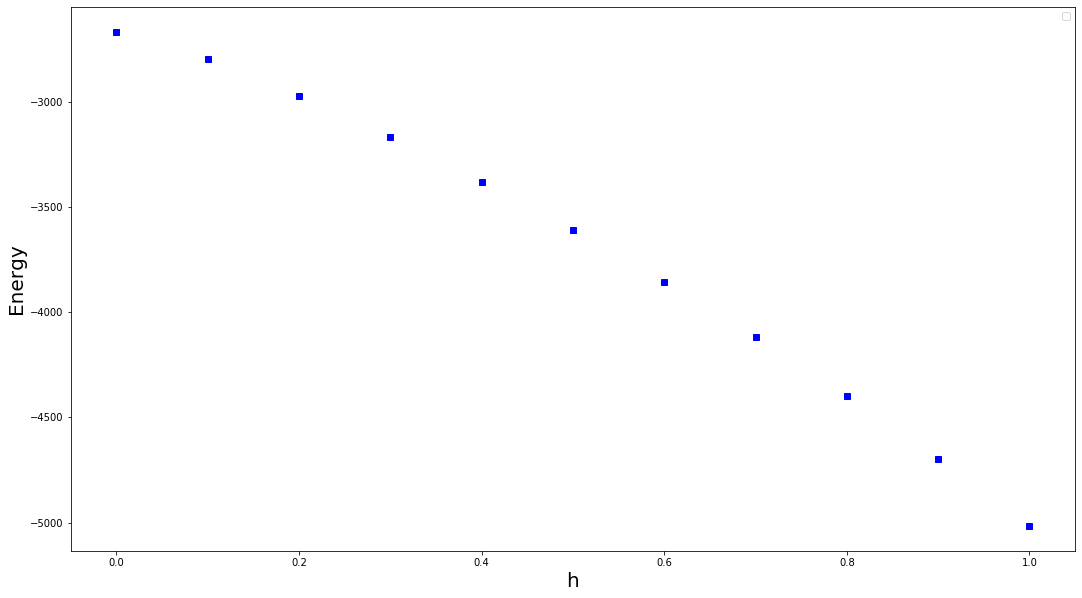

In [13]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 32
chid = 4
N = 20
print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 4 # number of DMRG sweeps
OPTS_dispon = 0 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 4

#printentrhdensmatr()

#printentrlocdensmatr() - это работающее

CalculateEnergy()